In [1]:
include("../src/GaussianFilters.jl")
using .GaussianFilters # . done before adding to package repo

using LinearAlgebra
using Distributions
using Random

Random.seed!(1);

2D Example motion example where you provide x and y force directly through an object; u = \[Fx, Fy\].

As such a = F/m, discrete dV = adt = F/mdt. Let state vector x consist of \[px, vx, py, vy\]

In [2]:
dt = 0.1
m = 50
A = [1 dt 0 0 ; 0 1 0 0 ; 0 0 1 dt; 0 0 0 1]
B = [0 0; dt/m 0; 0 0; 0 dt/m]
W = 0.5*Matrix{Float64}(I,4,4)
dmodel = LinearDynamicsModel(A,B,W)

LinearDynamicsModel{Float64,Float64,Float64}([1.0 0.1 0.0 0.0; 0.0 1.0 0.0 0.0; 0.0 0.0 1.0 0.1; 0.0 0.0 0.0 1.0], [0.0 0.0; 0.002 0.0; 0.0 0.0; 0.0 0.002], [0.5 0.0 0.0 0.0; 0.0 0.5 0.0 0.0; 0.0 0.0 0.5 0.0; 0.0 0.0 0.0 0.5])

Assume we can noisily measure velocity

In [3]:
C = [0 1.0 0 0; 0 0 0 1.0]
V = 0.5*Matrix{Float64}(I,2,2)
omodel = LinearObservationModel(C,V)
kf = KalmanFilter(dmodel,omodel)

KalmanFilter(LinearDynamicsModel{Float64,Float64,Float64}([1.0 0.1 0.0 0.0; 0.0 1.0 0.0 0.0; 0.0 0.0 1.0 0.1; 0.0 0.0 0.0 1.0], [0.0 0.0; 0.002 0.0; 0.0 0.0; 0.0 0.002], [0.5 0.0 0.0 0.0; 0.0 0.5 0.0 0.0; 0.0 0.0 0.5 0.0; 0.0 0.0 0.0 0.5]), LinearObservationModel{Float64,Bool,Float64}([0.0 1.0 0.0 0.0; 0.0 0.0 0.0 1.0], Bool[false false; false false], [0.5 0.0; 0.0 0.5]))

Initialize belief, generate action sequence (forces in a circle), simulate model 

In [4]:
times = 0:dt:10
Fmag = 1000
action_sequence = [[Fmag*cos(t), Fmag*sin(t)] for t in times]
b0 = GaussianBelief([0.0,0.0,0.0,0.0], 2.0*Matrix{Float64}(I,4,4))

sim_states, sim_measurements = simulation(b0,action_sequence,kf)

(Array{Float64,1}[[0.420429, 0.54079, -0.845183, -0.0147718], [-0.118774, 2.76078, 0.776212, -1.61784], [0.570048, 5.43192, 0.938842, -1.78752], [0.622753, 6.13777, 0.845484, -1.92591], [1.71034, 8.43795, 0.60808, -0.389512], [1.69142, 10.2425, 0.45236, -1.10647], [3.11709, 12.5375, 0.609423, -0.604123], [3.45935, 13.9511, 0.598839, 0.766847], [5.00038, 14.7674, 0.0744431, 2.8539], [6.43777, 16.6978, 0.338431, 4.03328]  …  [45.4879, 2.67113, 139.11, 35.4251], [45.9388, 1.05117, 142.375, 34.9595], [45.5979, -0.476859, 146.674, 35.801], [45.2399, -2.83283, 150.255, 34.8677], [45.1777, -5.06658, 153.868, 34.7227], [43.5927, -8.05481, 157.278, 34.2049], [41.9103, -10.8553, 160.824, 32.9403], [40.0735, -12.8438, 163.567, 32.3495], [38.5991, -13.0059, 166.801, 32.0517], [36.6189, -15.0095, 170.676, 31.1904]], Array{Float64,1}[[3.13552, -1.31278], [5.7207, -1.8232], [4.91464, -1.36309], [8.38623, -0.916635], [10.1953, -0.242057], [12.0675, -1.87906], [15.1781, 1.68603], [13.8139, 3.73091], [1

In [5]:
filtered_beliefs = run_filter(b0, action_sequence, sim_measurements, kf)
μ, Σ = beautify(filtered_beliefs;dims=[1,3])

([0.0 0.0; 0.0757014 -0.0875189; … ; 52.2284 160.511; 50.9291 163.699], [2.0 0.0; 2.50667 0.0; … ; 52.5051 0.0; 53.0101 0.0]

[0.0 2.0; 0.0 2.50667; … ; 0.0 52.5051; 0.0 53.0101])

### Plot

In [6]:
using Plots

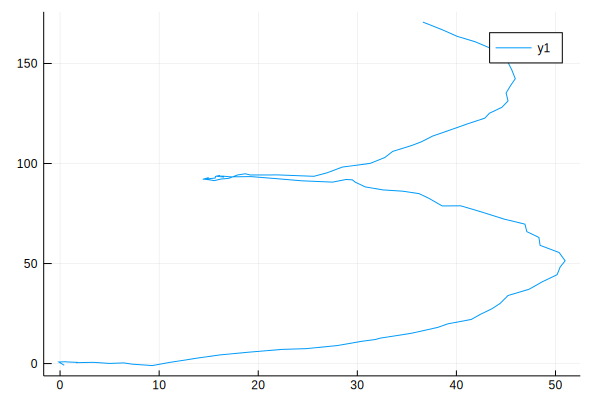

In [7]:
x = [x[1] for x in sim_states]
y = [x[3] for x in sim_states]
plot(x, y)

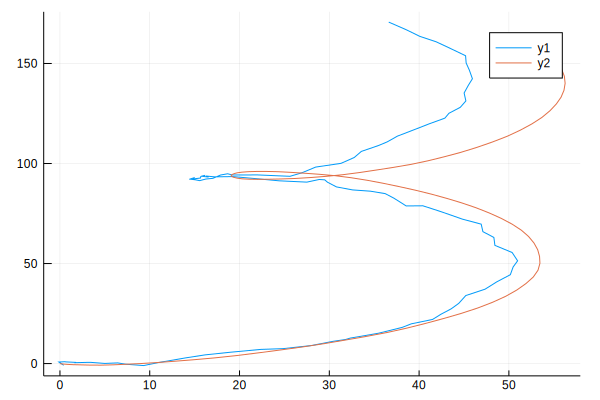

In [8]:
plot!(μ[:,1], μ[:,2])

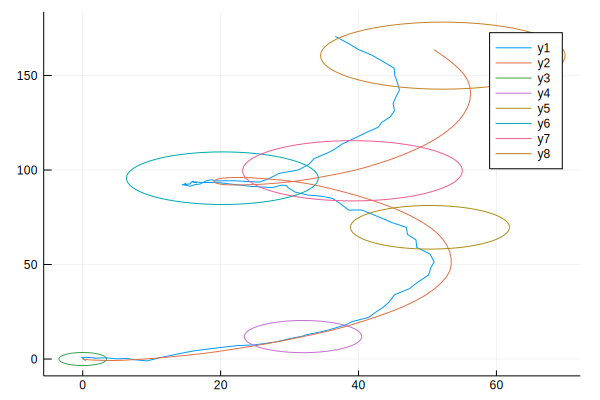

In [9]:
for i in 1:20:size(μ,1)
    x,y = beliefEllipse(μ[i,:], Σ[i,:,:])
    plot!(x,y)
end
plot!()

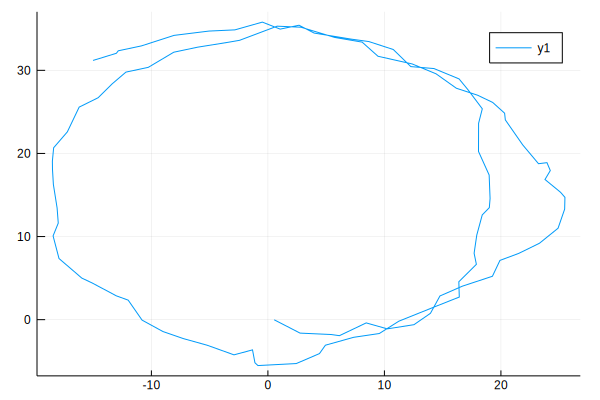

In [10]:
vx = [x[2] for x in sim_states]
vy = [x[4] for x in sim_states]
plot(vx, vy)